# Dendrogram samples

This notebook applies the methods explored in [progress_report_4.ipynb](progress_report_4.ipynb) to an assortment of poems with different properties. It begins by consolidating the run script into a function, which is then called against different samples.

## Reload libraries each time, since we’re tinkering with them

In [1]:
%load_ext autoreload
%autoreload 2

## Load libraries

In [2]:
from xml.dom import pulldom  # parse input XML
from xml.dom.minidom import Document  # construct output XML
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
# see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from cyr2phon import cyr2phon  # custom package
pd.set_option('display.max_colwidth', -1) # show all text in cell, without truncation; default is 50

## Class and variables for parsing input XML

In [3]:
class Stack(list):  # keep track of open nodes while constructing XML output
    def push(self, item):
        self.append(item)

    def peek(self):  
        return self[-1]


open_elements = Stack()
WS_RE = re.compile(r'\s+')  # normalize white space in output

## Function to parse the XML

Returns a list of lists, with stanza number, line number, and `<line>` element for each line. We use the light-weight *xml.dom.pulldom* library to parse the input XML and *xml.dom.minidom* to construct the lines as simplified XML, removing elements we don’t care about, such as `<latin>` and `<italic>`, before serializing them to the output. (We actually do care about `<latin>`, but we are ignoring it temporarily, and we’ll return to it at a later stage in the project.)

In [4]:
def process(input_xml):
    poemId = ""
    stanzaNo = 0
    lineNo = 0
    inline = 0  # flag to control behavior inside and outside lines
    result = []  # array of arrays, one per line, with stanzaNo, lineNo, and serialized XML
    doc = pulldom.parse(input_xml)
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.localName == 'poem':
            poemId = node.getAttribute("opid")
        elif event == pulldom.START_ELEMENT and node.localName == 'stanza':
            stanzaNo = node.getAttribute("stanzaNo")
        elif event == pulldom.START_ELEMENT and node.localName == 'line':
            d = Document()  # each line is an output XML document
            open_elements.push(d)  # document node
            lineNo = node.getAttribute("lineNo")
            inline = 1  # we’re inside a line
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'line':
            inline = 0  # when we finish our work here, we’ll no longer be inside a line
            open_elements.pop()  # line is finished
            # serialize XML, strip declaration, rewrite &quot; entity as character
            result.append([poemId, int(stanzaNo), (lineNo),
                WS_RE.sub(" " ,
                open_elements.pop().toxml().replace('<?xml version="1.0" ?>', '').replace('&quot;', '"'))])
        elif event == pulldom.START_ELEMENT and node.localName == 'stress':
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'stress':
            open_elements.pop()  # stress element is finished
        elif event == pulldom.CHARACTERS and inline:  # keep text only inside lines
            t = d.createTextNode(node.data)
            open_elements.peek().appendChild(t)
    return result

## Function to extract rhyme zone from rhyme word

In [5]:
rhymezonepat = re.compile(r'(.?[AEIOU]$)|([AEIOU][^AEIOU]*$)')
def remove_pretonic_segments(s: str) -> str: # removes segments in place
    try:
        return rhymezonepat.search(s.replace(' ', '')).group(0)
    except: # modify this to raise a real error, instead of just reporting
        print('Error: ', s)

## Imports sample file, analyzes, outputs reports

In [18]:
def explore(filepath, ceiling=1000, ward=None):
    '''Render text and dendrograms of rhyme clustering
    
    Parameters:
        filepath (str): path to XML file with poem, required
        ceiling (int): maximum number of stanzas to return (useful for sampling long poems), 
            defaults to high value
        ward (boolean): show Ward dendrogram separately (improves legibility of long stanzas),
            defaults to None
    
    Does not return a value; all output is written directly from within the function
    '''
    
    # Read file
    with open(filepath) as f:
        data = process(f)
    df = pd.DataFrame(data, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
    
    # Prepare data
    # Prepare data
    trans_vec = np.vectorize(cyr2phon.transliterate)
    df["Phonetic"] = trans_vec(df["Text"])
    df["RhymeZone"] = df["Phonetic"].apply(remove_pretonic_segments)
#     df.loc[df["RhymeZone"].isnull(), "RhymeZone"] = "Abcde" # provisional placeholder for nulls
    df["tokenized"] = [x[0] for x in df["RhymeZone"].str.
                       findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]

    i = 0
    while i == 0 or pd.np.count_nonzero([item[i] for item in df["tokenized"]]) > 0:
        print([item[i] for item in df["tokenized"]]) # diagnostic
        df["token" + str(i)] = [item[i] for item in df["tokenized"]]
        i += 1
    tokenheaders = df.filter(regex="^token\d").columns
    df[tokenheaders] = df[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
    df.filter(regex=r"StanzaNo|LineNo|Text|^token\d").head() # columns we care about
    dummy = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)
    df = df.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeZone", "tokenized"])
    df.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
    
    # Visualize
    methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    stanzas = df.groupby(level=[0,1])
    pd.set_option('display.width', 1000) # don't wrap long rows
    for offset, (id, lines) in enumerate(stanzas):
        if offset < ceiling:
            print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines[["RhymeZone"]]], axis=1)) # diagnostic
            data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
            missing = data.filter(regex=r"missing$")
            missing = missing * 0.2 # reduce weight of missing values
            labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
            data.loc[:,"LineNo"] = [n / (len(labelList) * 2) for n in labelList] # scale to avoid tyranny of proximity, currently 0 <= n <= 0.5
            plt.figure(figsize=(20, 2))
            for n, m in enumerate(methods):
                linked = linkage(data, method=m)
                m_c, m_coph_dist = cophenet(linked, pdist(data))
                plt.subplot(1, 7, n + 1)
                plt.title(m + ": " + str(round(m_c, 3)))
                dendrogram(linked, labels=labelList)
            plt.show()
            if ward:
                linked = linkage(data, method="ward")
                labelList=list(range(1,len(lines)+1))
                c, coph_dist = cophenet(linked, pdist(data))
                plt.figure(figsize=(20, 10))
                plt.title("Ward: " + str(c))
                dendrogram(linked, labels=labelList)
                plt.show()
    pd.set_option('display.width', 80) # restore default
    return df

## Zinaida Gippius, “Neljubov′” (1907)

['', '', '', '', '', 'J', '', 'J', '', 'V', '', 'V', '', 'R', '', 'R']
['A', 'O', 'A', 'O', 'E', 'U', 'E', 'U', 'O', 'I', 'O', 'I', 'I', 'U', 'I', 'U']
['vN', 'J', 'vN', 'J', 'J', '', 'J', '', 'K', '', 'K', '', 'tv', '', 'tv', '']
['i', '', 'i', '', 'u', '', 'u', '', 'i', '', 'i', '', 'u', '', 'u', '']
['', '', 'J', '', '', '', '', '', 'J', '', 'J', '', '', '', '', '']
                                                                    Text RhymeZone
PoemId           StanzaNo LineNo                                                  
gippius_neljubov 1        001     Как ветер мокрый, ты бьешься в ставни,  AvNi    
                          002     Как ветер черный, поешь: ты мой!        OJ      
                          002     Я древний хаос, я друг твой давний,     AvNiJ   
                          004     Твой друг единый,— открой, открой!      OJ      


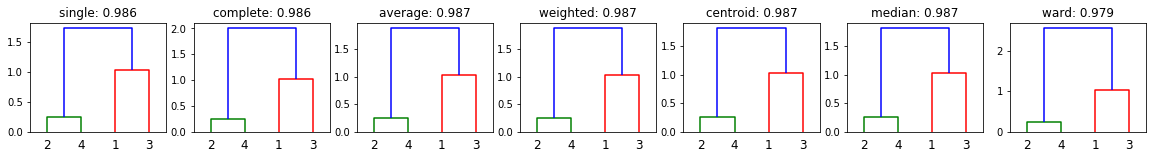

                                                              Text RhymeZone
PoemId           StanzaNo LineNo                                            
gippius_neljubov 2        001     Держу я ставни, открыть не смею,  EJu     
                          002     Держусь за ставни и страх таю.    JU      
                          003     Храню, лелею, храню, жалею        EJu     
                          004     Мой луч последний — любовь мою.   JU      


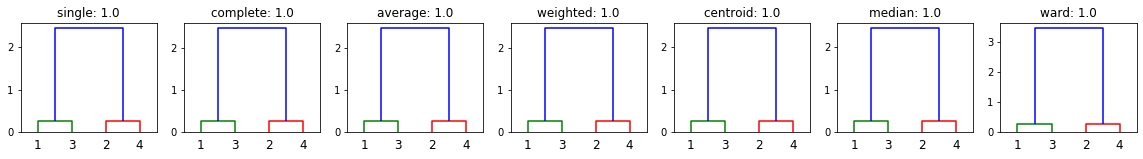

                                                              Text RhymeZone
PoemId           StanzaNo LineNo                                            
gippius_neljubov 3        001     Смеется хаос, зовет безокий:      OKiJ    
                          002     Умрешь в оковах,— порви, порви!   VI      
                          003     Ты знаешь счастье, ты одинокий,   OKiJ    
                          004     В свободе счастье — и в Нелюбви.  VI      


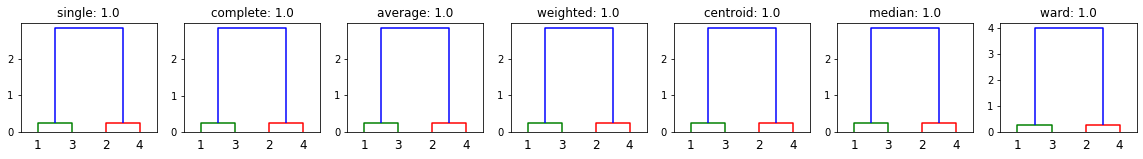

                                                         Text RhymeZone
PoemId           StanzaNo LineNo                                       
gippius_neljubov 4        001     Охладевая, творю молитву,    Itvu    
                          002     Любви молитву едва творю…    RU      
                          003     Слабеют руки, кончаю битву,  Itvu    
                          004     Слабеют руки… Я отворю!      RU      


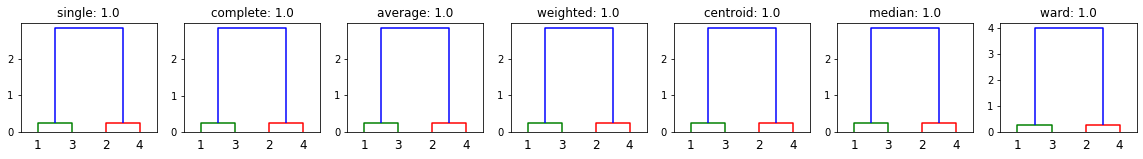

Text  \
PoemId           StanzaNo LineNo                                                                                      
gippius_neljubov 1        001     <line lineNo="001">Как ветер мокрый, ты бьешься в ст<stress>а</stress>вни,</line>   
                          002     <line lineNo="002">Как ветер черный, поешь: ты м<stress>о</stress>й!</line>         
                          002     <line lineNo="002">Я древний хаос, я друг твой д<stress>а</stress>вний,</line>      
                          004     <line lineNo="004">Твой друг единый,— открой, откр<stress>о</stress>й!</line>       
                 2        001     <line lineNo="001">Держу я ставни, открыть не см<stress>е</stress>ю,</line>         
                          002     <line lineNo="002">Держусь за ставни и страх та<stress>ю</stress>.</line>           
                          003     <line lineNo="003">Храню, лелею, храню, жал<stress>е</stress>ю</line>               
                          004     <line lineNo="004">Мой луч последний — любовь мо<stress>ю</stress>.</line>          
                 3        001     <line lineNo="001">Смеется хаос, зовет без<stress>о</stress>кий:</line>             
                          002     <line lineNo="002">Умрешь в оковах,— порви, порв<stress>и</stress>!</line>          
                          003     <line lineNo="003">Ты знаешь счастье, ты один<stress>о</stress>кий,</line>          
                          004     <line lineNo="004">В свободе счастье — и в Нелюбв<stress>и</stress>.</line>         
                 4        001     <line lineNo="001">Охладевая, творю мол<stress>и</stress>тву,</line>                
                          002     <line lineNo="002">Любви молитву едва твор<stress>ю</stress>…</line>                
                          003     <line lineNo="003">Слабеют руки, кончаю б<stress>и</stress>тву,</line>              
                          004     <line lineNo="004">Слабеют руки… Я отвор<stress>ю</stress>!</line>                  

                                                           Phonetic RhymeZone  \
PoemId           StanzaNo LineNo                                                
gippius_neljubov 1        001     kak ViTir makriJti BJišSi fstAvNi  AvNi       
                          002     kak ViTir ČirniJ paJišti mOJ       OJ         
                          002     Ji dRivNiJ xaaSi druk tvaJ dAvNiJ  AvNiJ      
                          004     tvaJ druk JiDiniJ atkraJ atkrOJ    OJ         
                 2        001     DiržuJi stavNi atkriT NisMEJu      EJu        
                          002     DiržuS zastavNi istrax taJU        JU         
                          003     xraNu LiLiJu xraNu žaLEJu          EJu        
                          004     maJ luČ paSLiDNiJ LubaF maJU       JU         
                 3        001     sMiJiTSi xaas zaVit BizOKiJ        OKiJ       
                          002     umRiš vakavax parVi parVI          VI         
                          003     ti znaJiš SČiSTJiti aDinOKiJ       OKiJ       
                          004     fsvabaDi SČiSTJi ivNiLubVI         VI         
                 4        001     axlaDivaJi tvaRu maLItvu           Itvu       
                          002     LubVi maLitvu Jidva tvaRU          RU         
                          003     slaBiJut ruKi kaNČiJu BItvu        Itvu       
                          004     slaBiJut ruKiJi atvaRU             RU         

                                                                  tokenized  \
PoemId           StanzaNo LineNo                                              
gippius_neljubov 1        001     (, A, vN, i, , , , , , , , , , , , , , )    
                          002     (, O, J, , , , , , , , , , , , , , , )      
                          002     (, A, vN, i, J, , , , , , , , , , , , , )   
                          004     (, O, J, , , , , , , , , , , , , , , )      
                 2        001     (

In [19]:
explore("data_samples/gippius_neljubov.xml")

## Cvetaeva “Novogodnee”

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['O', 'O', 'A', 'U', 'A', 'A', 'O', 'O', 'O', 'O', 'A', 'A', 'I', 'I', 'I', 'I', 'E', 'E', 'A', 'A', 'O', 'O', 'U', 'U', 'A', 'A', 'I', 'I', 'O', 'O', 'E', 'E', 'O', 'O', 'U', 'U', 'U', 'U', 'E', 'E', 'E', 'E', 'O', 'O', 'A

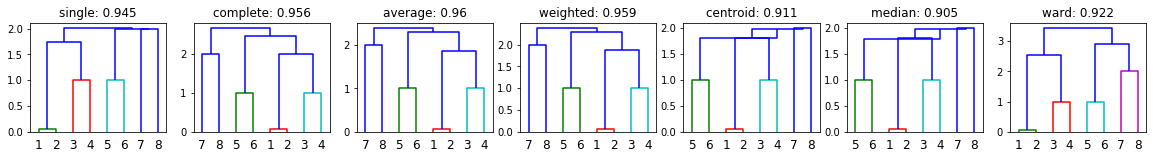

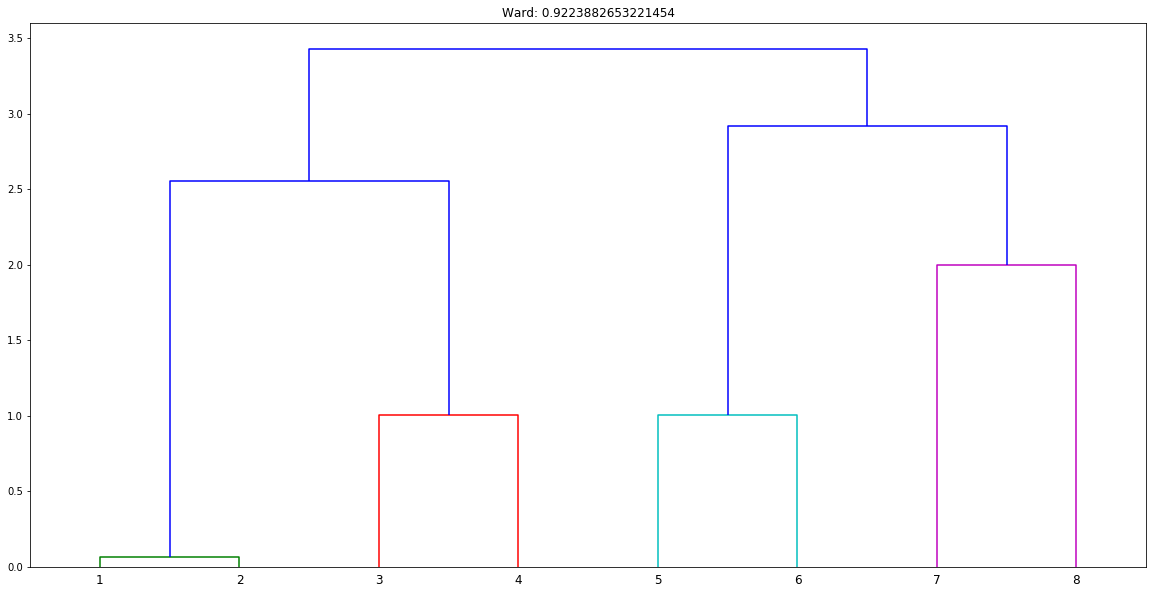

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 2        009     Звезд… Закон отхода и отбоя,             OJi     
                               010     По которому любимая любою                OJu     
                               011     И небывшею из небывалой.                 AlaJ    
                               012     Рассказать, как про твою узнала?         Ala     
                               013     Не землетрясенье, не лавина.             Ina     
                               014     Человек вошел — любой — (любимый —       ImiJ    
                               015     Ты). — Прискорбнейшее из событий.        ITiJ    
                               016     — В Новостях и в Днях. — Статью дадите?  ITi     


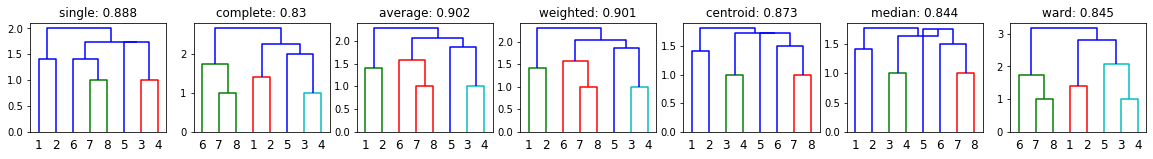

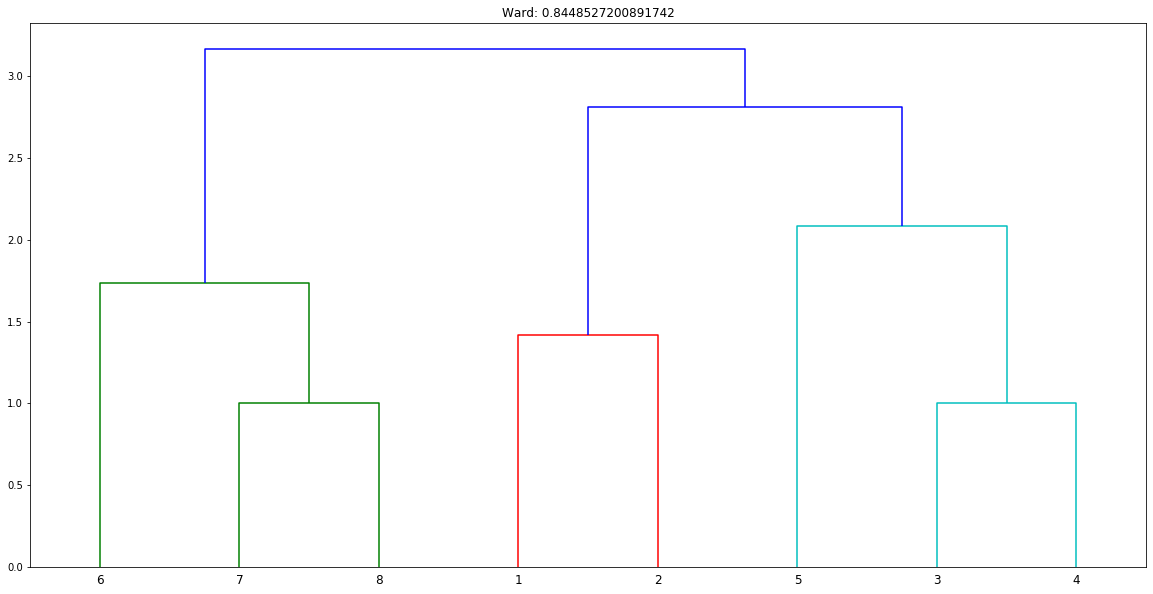

                                                                             Text RhymeZone
PoemId                StanzaNo LineNo                                                      
cvetaeva_novogodnee_y 3        017     — Где? — В горах. (Окно в еловых ветках.    Etkax   
                               018     Простыня.) — Не видите газет ведь?          EtViT   
                               019     Так статью? — Нет. — Но… — Прошу избавить.  AViT    
                               020     Вслух: трудна. Внутрь: не христопродавец.   AVits   
                               021     — В санатории. (В раю наёмном.)             Omnam   
                               022     — День? — Вчера, позавчера, не помню.       OmNu    
                               023     В Альказаре будете? — Не буду.              Udu     
                               024     Вслух: семья. Внутрь: всё, но не Иуда.      Uda     


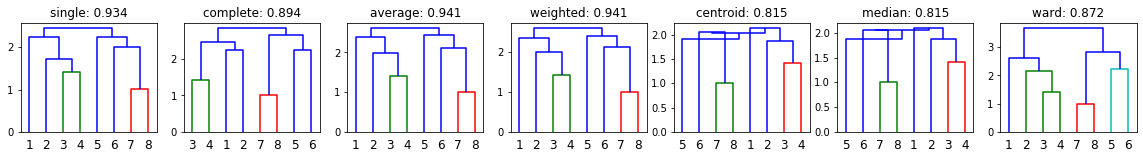

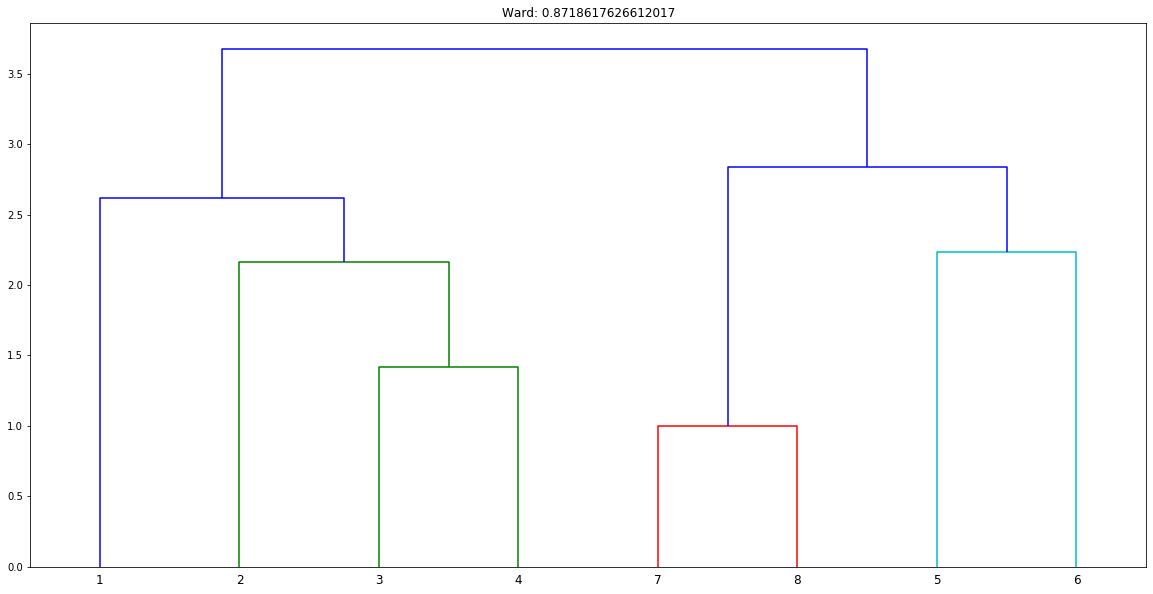

                                                                         Text RhymeZone
PoemId                StanzaNo LineNo                                                  
cvetaeva_novogodnee_y 4        025      С наступающим! (Рождался завтра!) —    Aftra   
                               026      Рассказать, что сделала, узнав про..?  Afpra   
                               027      Тсс… Оговорилась. По привычке.         IČKi    
                               028      Жизнь и смерть давно беру в кавычки,   IČKi    
                               029      Как заведомо-пустые сплёты.            Oti     
                               030      Ничего не сделала, но что-то           O-ta    
                               031      Сделалось, без тени и без эха          Exa     
                               032–033  Делающее! Теперь — как ехал?           Exal    


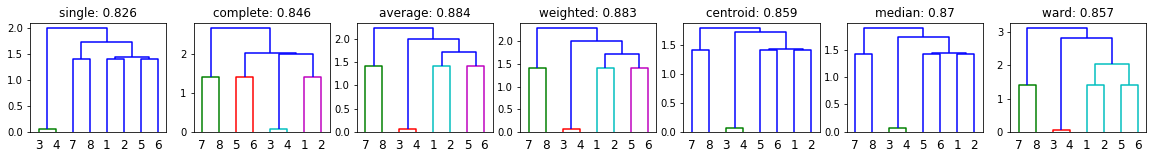

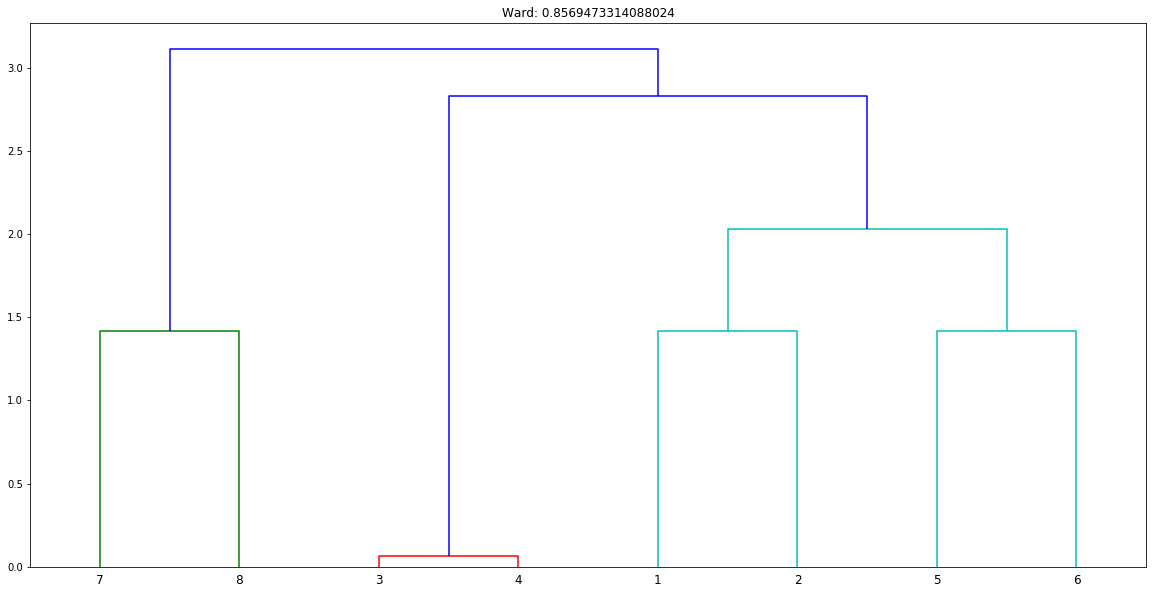

                                                                         Text RhymeZone
PoemId                StanzaNo LineNo                                                  
cvetaeva_novogodnee_y 5        034     Как рвалось и не разорвалось как —      OSkak   
                               035     Сердце? Как на рысаках орловских,       OfsKix  
                               036     От орлов, сказал, не отстающих,         UQix    
                               037     Дух захватывало — или пуще?             UQi     
                               038     Слаще? Ни высот тому, ни спусков        Uskaf   
                               039     На орлах летал заправских русских —     UsKix   
                               040     Кто. Связь кровная у нас с тем светом:  Etam    
                               041     На Руси бывал — тoт свет на этом        Etam    


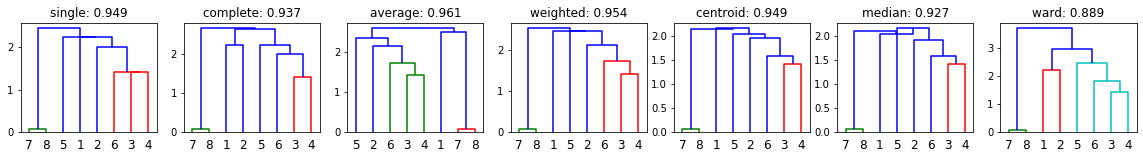

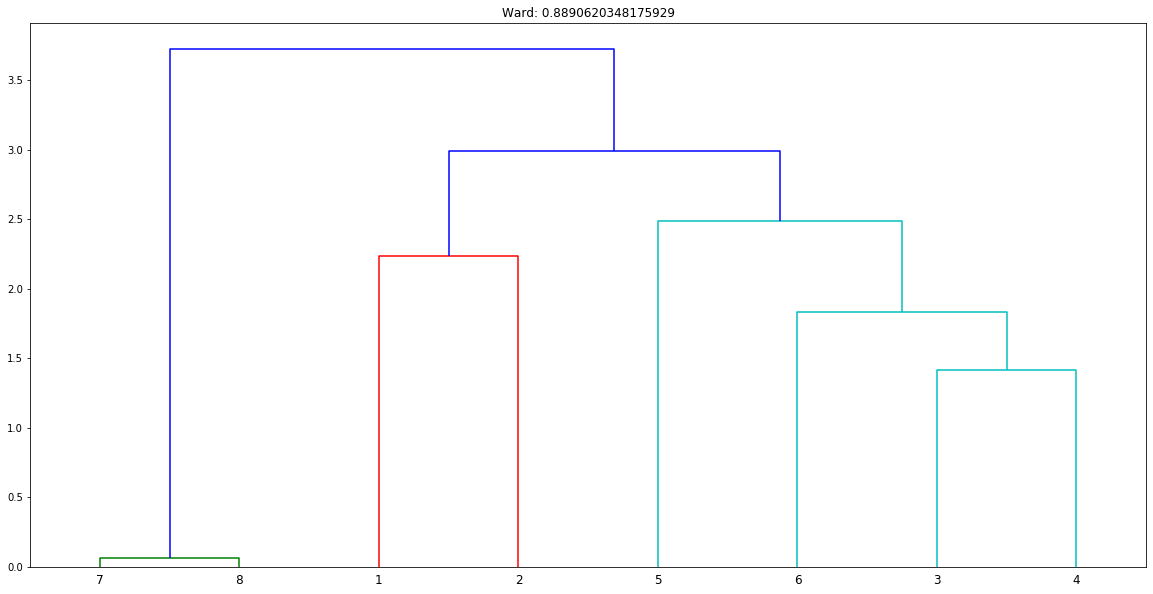

                                                                        Text RhymeZone
PoemId                StanzaNo LineNo                                                 
cvetaeva_novogodnee_y 6        042      Зрел. Налаженная перебежка!           Eška    
                               043      Жизнь и смерть произношу с усмешкой,  EškaJ   
                               044      Скрытою — своей ее коснёшься!         OšSi    
                               045      Жизнь и смерть произношу со сноской,  OskaJ   
                               046      Звездочкою (ночь, которой чаю:        AJu     
                               047      Вместо мозгового полушарья —          ARJi    
                               048–049  Звёздное!) Не позабыть бы, друг мой,  UkmaJ   
                               050      Следующего: что если буквы            Ukvi    


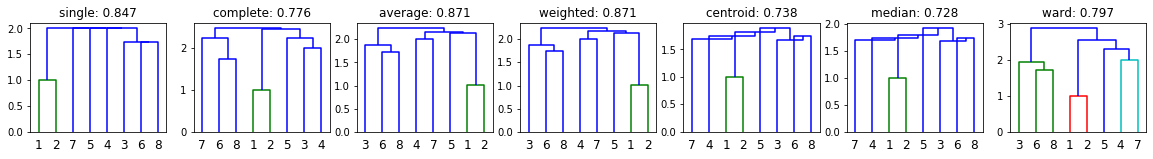

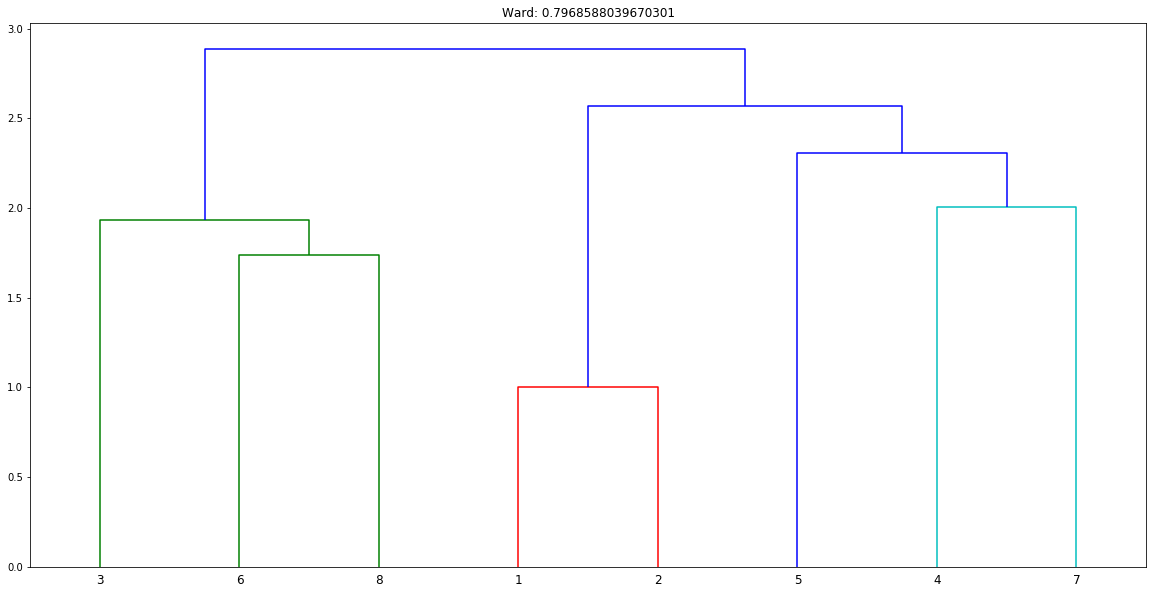

                                                                              Text RhymeZone
PoemId                StanzaNo LineNo                                                       
cvetaeva_novogodnee_y 7        051     Русские пошли взамен немецких —              EtsKix  
                               052     То не потому, что нынче, дескать,            EskaT   
                               053     Всё сойдет, что мертвый (нищий) все съест —  Est     
                               054     Не сморгнет! — а потому что тот свет,        Et      
                               055     Наш, — тринадцати, в Новодевичьем            IČJim   
                               056     Поняла: не без- а вс?-язычен.                IČin    
                               057     Вот и спрашиваю не без грусти:               USTi    
                               058     Уж не спрашиваешь, как по-русски             UsKi    


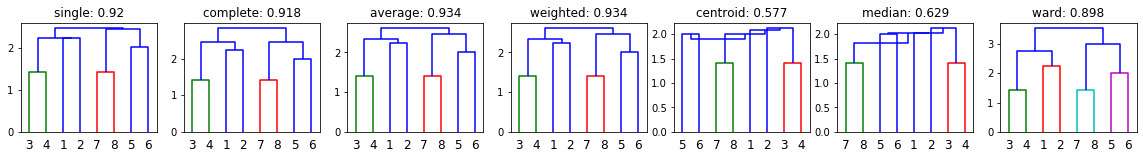

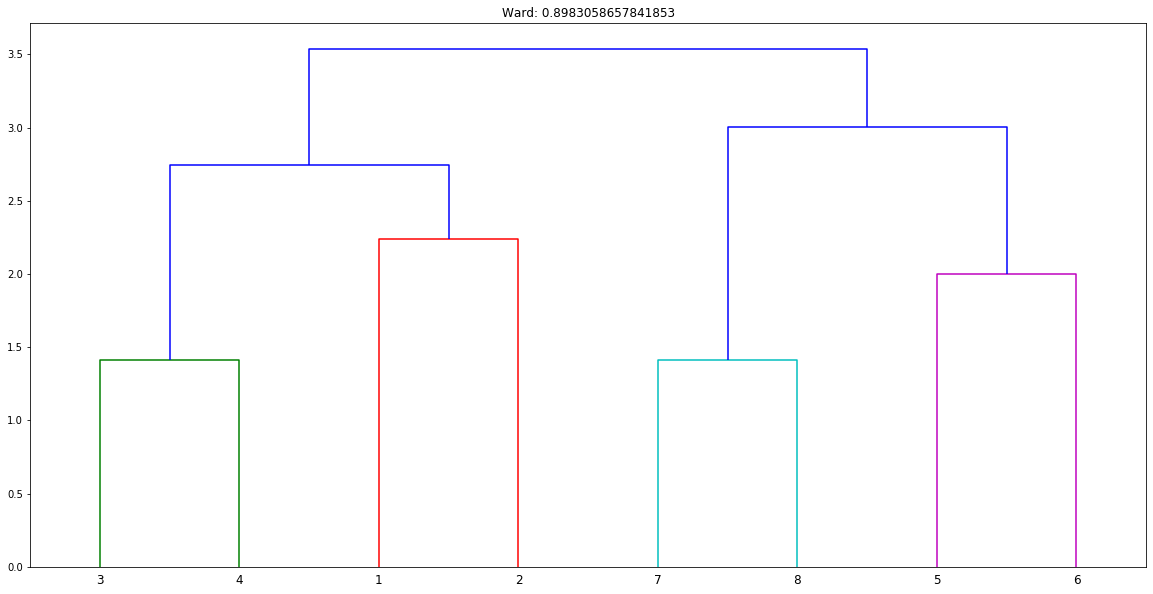

                                                                            Text RhymeZone
PoemId                StanzaNo LineNo                                                     
cvetaeva_novogodnee_y 8        059     Nest? Единственная, и все гнёзда           Ozda    
                               060     Покрывающая рифма: звёзды.                 Ozdi    
                               061     Отвлекаюсь? Но такой и вещи                EQi     
                               062     Не найдется — от тебя отвлечься.           EČSi    
                               063     Каждый помысел, любой, Du Lieber,          Ebir    
                               064     Слог в тебя ведет — о чем бы ни был        Ibil    
                               065     Толк (пусть русского родней немецкий       EtsKiJ  
                               066     Мне, всех ангельский родней!) — как места  Esta    


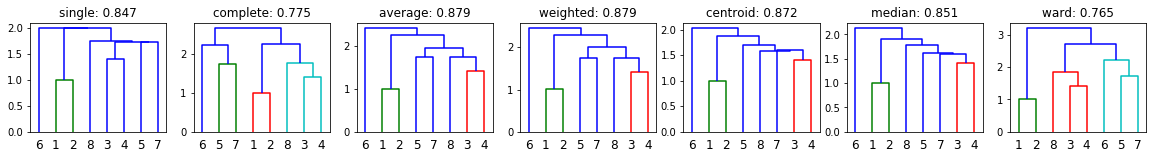

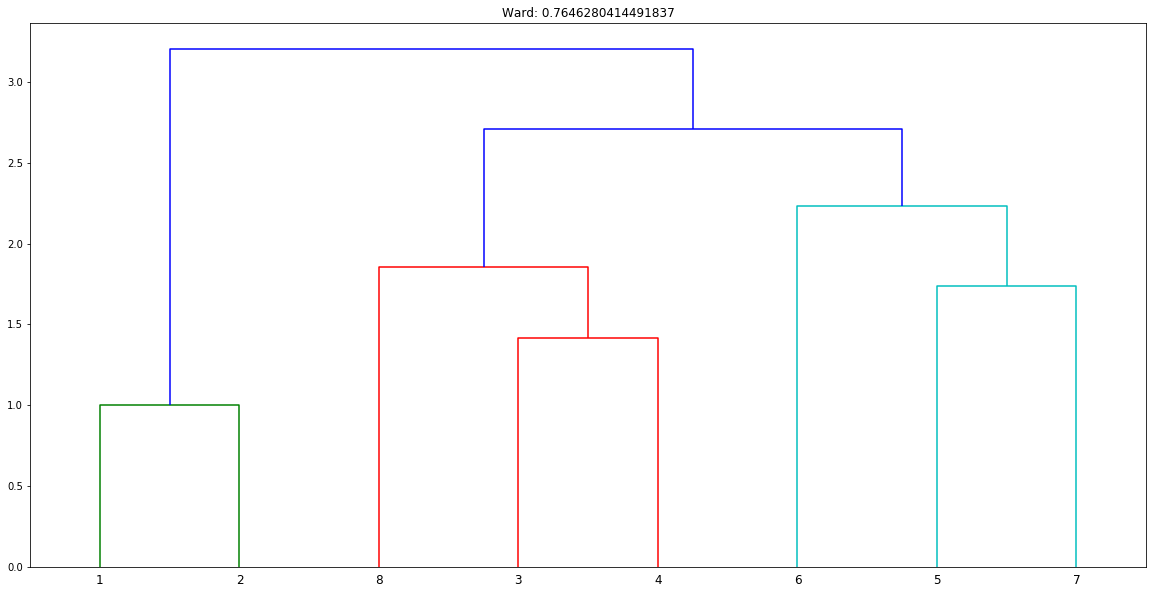

                                                                         Text RhymeZone
PoemId                StanzaNo LineNo                                                  
cvetaeva_novogodnee_y 9        067     Несть, где нет тебя, нет есть: могила.  Ila     
                               068     Всё как не было и всё как было,         Ila     
                               069     — Неужели обо мне ничуть не? —          UTNi    
                               070     Окруженье, Райнер, самочувствье?        UfstVJi 
                               071     Настоятельно, всенепременно —           Ena     
                               072     Первое видение вселенной                EnaJ    
                               073     (Подразумевается, поэта                 Eta     
                               074     В оной) и последнее — планеты,          Eti     


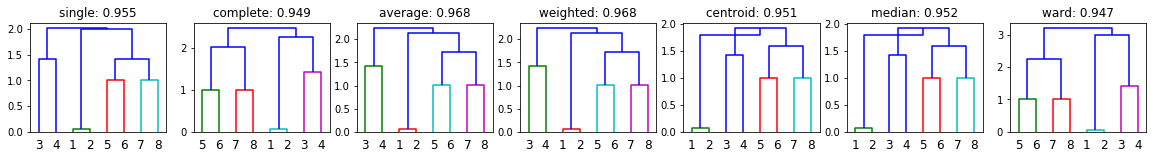

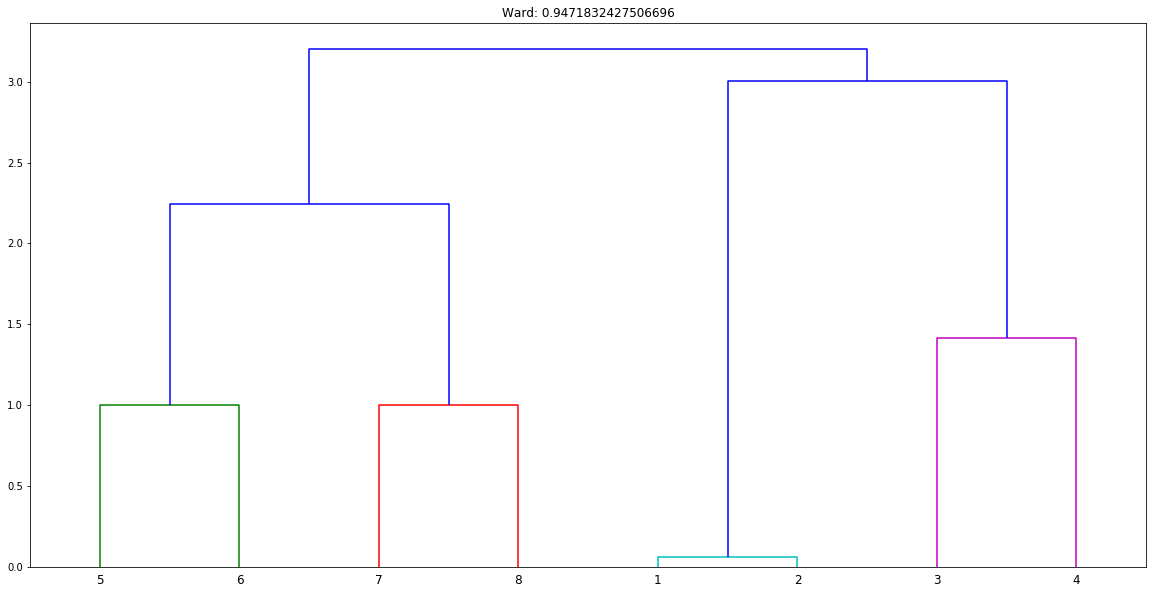

                                                                      Text RhymeZone
PoemId                StanzaNo LineNo                                               
cvetaeva_novogodnee_y 10       075     Раз только тебе и данной — в целом!  Elam    
                               076     Не поэта с прахом, духа с телом,     Elam    
                               077     (Обособить — оскорбить обоих)        OJix    
                               078     А тебя с тобой, тебя с тобою ж,      OJuš    
                               079     — Быть Зевесовым не значит лучшим —  UČšim   
                               080     Кастора — тебя с тобой — Поллуксом,  Uksam   
                               081     Мрамора — тебя с тобою, травкой,     AfkaJ   
                               082     Не разлуку и не встречу — ставку     Afku    


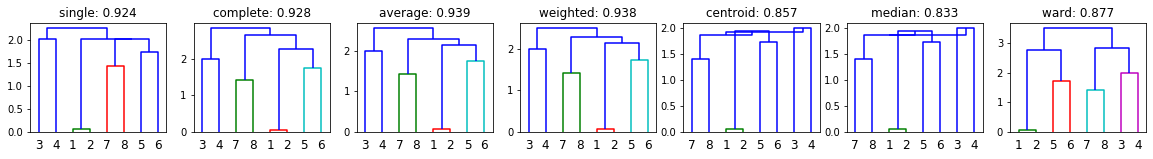

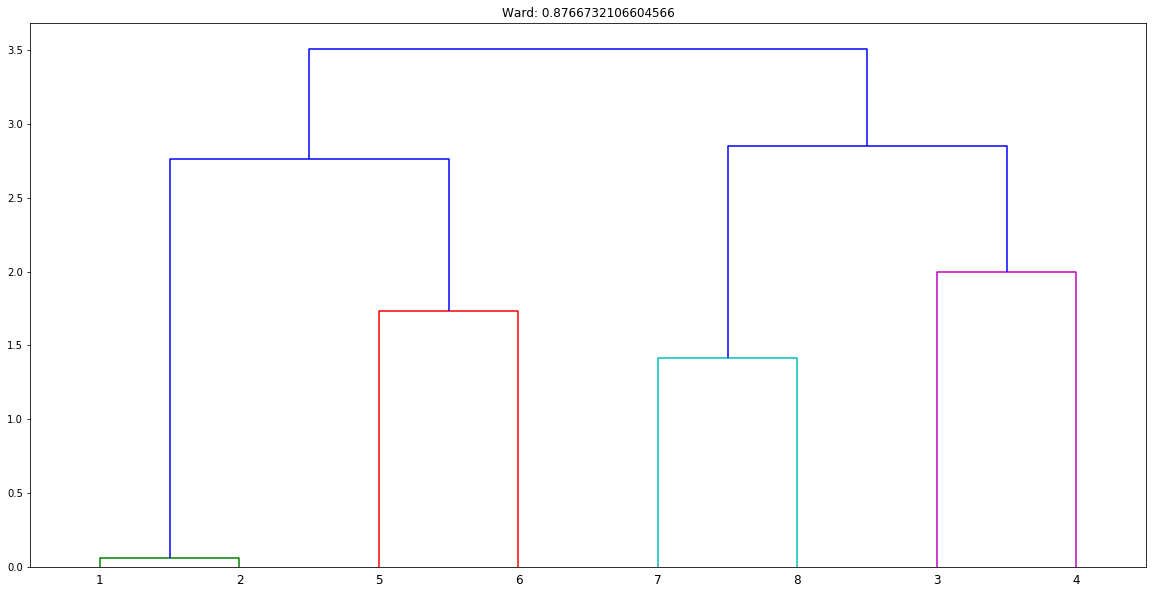

                                                                              Text RhymeZone
PoemId                StanzaNo LineNo                                                       
cvetaeva_novogodnee_y 11       083      Очную: и встречу и разлуку                  Uku     
                               084–085  Первую. На собственную руку                 Uku     
                               086      Как глядел (на след — на ней — чернильный)  ILniJ   
                               087      Со своей столько-то (сколько?) мильной      ILnaJ   
                               088      Бесконечной ибо безначальной                ALnaJ   
                               089      Высоты над уровнем хрустальным              ALnim   
                               090      Средиземного — и прочих блюдец.             UDits   
                               091      Всё как не было и всё как будет             UDit    


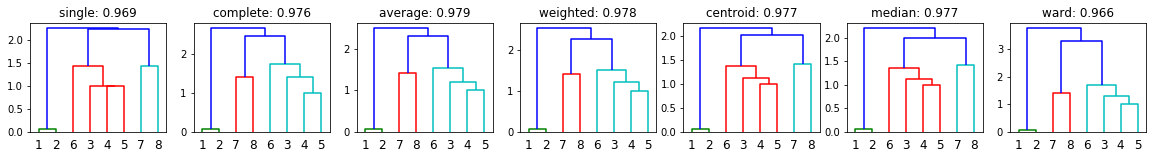

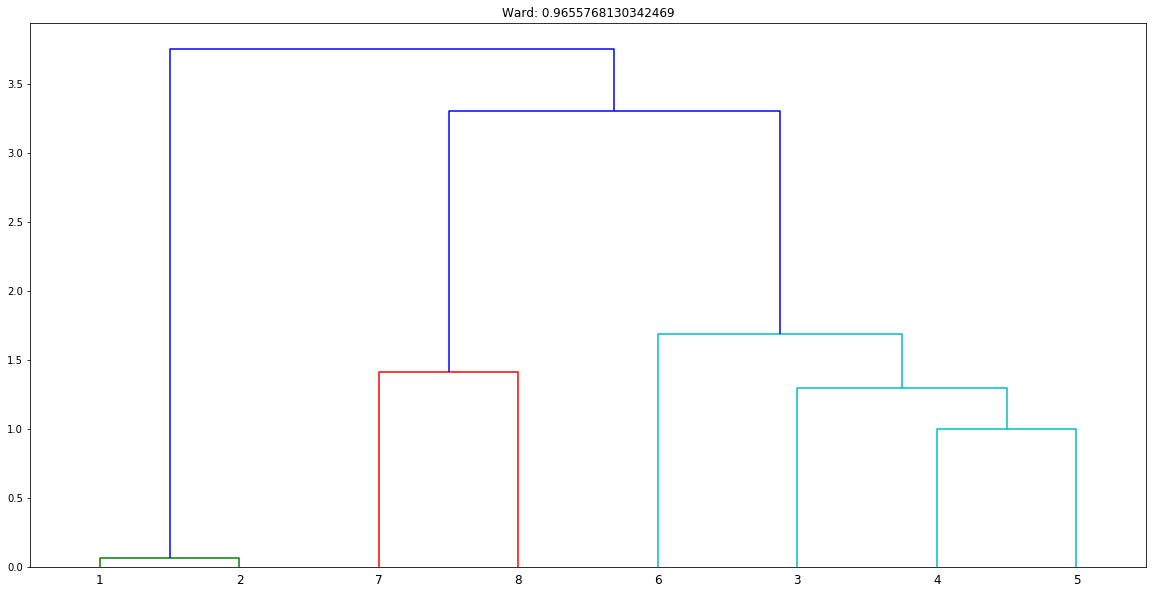

                                                                       Text RhymeZone
PoemId                StanzaNo LineNo                                                
cvetaeva_novogodnee_y 12       092     И со мною за концом предместья.       ESTJi   
                               093     Всё как не было и всё как есть уж     ESTuš   
                               094     — Что списавшемуся до недельки        ELKi    
                               095     Лишней! — и куда ж еще глядеть-то,    ET-ta   
                               096     Приоблокотясь на обод ложи,           Oži     
                               097     С этого — как не на тот, с того же —  Oži     
                               098     Как не на многострадальный этот.      Etat    
                               099     В Беллевю живу. Из гнезд и веток      Etak    


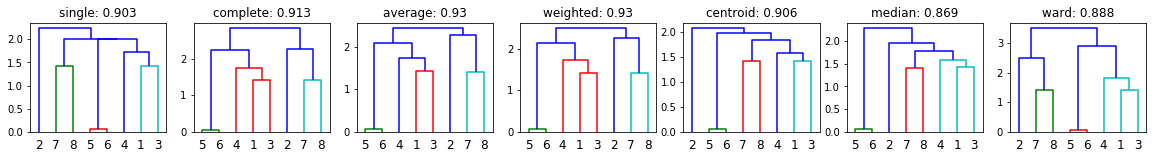

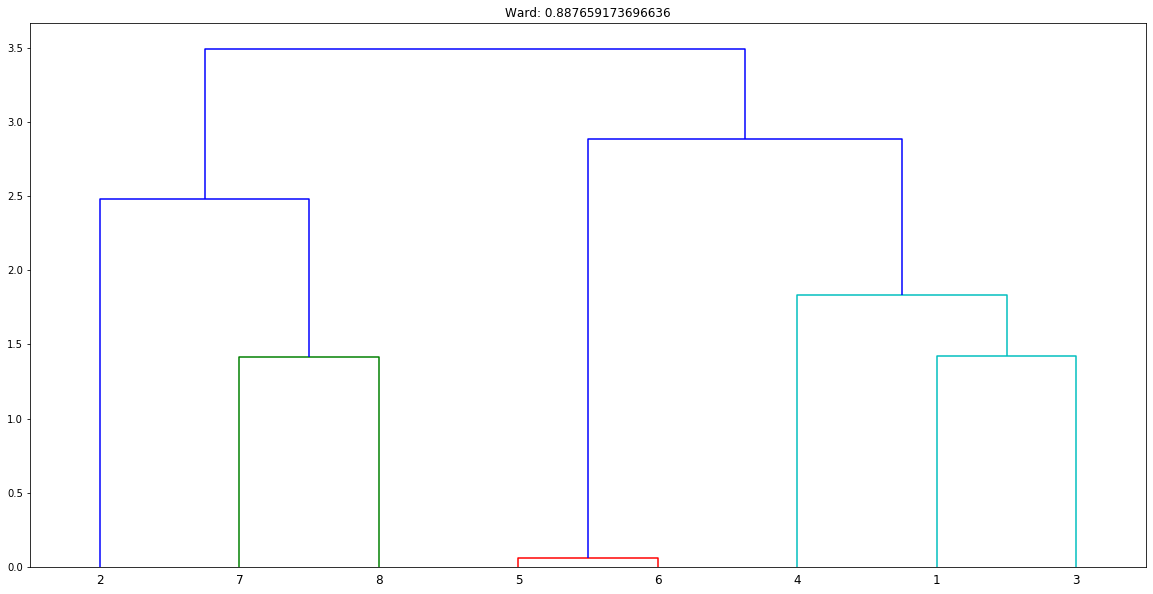

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 13       100     Городок. Переглянувшись с гидом:         Idam    
                               101     Беллевю. Острог с прекрасным видом       Idam    
                               102     На Париж — чертог химеры галльской —     AlLskaJ 
                               103     На Париж — и на немножко дальше…         ALši    
                               104     Приоблокотясь на алый обод,              Obat    
                               105     Как тебе смешны (кому) «должно быть»,    ObiT    
                               106     (Мне ж) должны быть, с высоты без меры,  Eri     
                               107     Наши Беллевю и Бельведеры!               Eri     


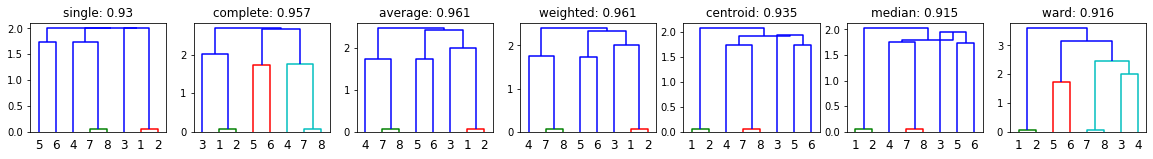

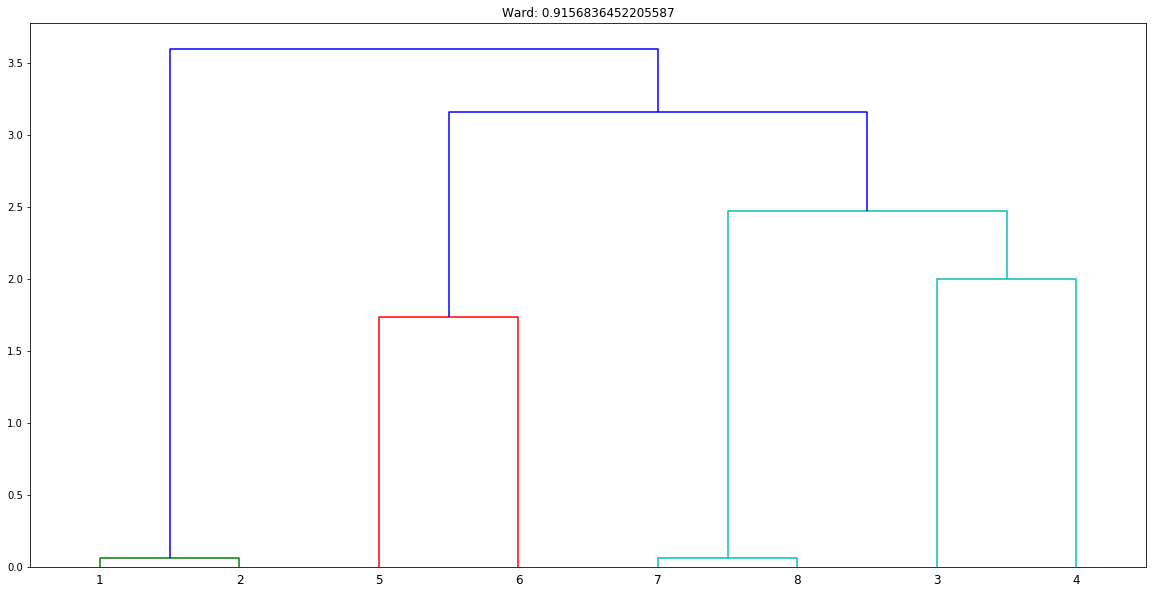

                                                                                      Text RhymeZone
PoemId                StanzaNo LineNo                                                               
cvetaeva_novogodnee_y 14       108     Перебрасываюсь. Частность. Срочность.                OČnaST  
                               109     Новый Год в дверях. За что, с кем чокнусь            OknuS   
                               110     Через стол? Чем? Вместо пены — ваты                  Ati     
                               111     Клок. Зачем? Ну, бьет — а при чем я тут?             Atut    
                               112     Что мне делать в новогоднем шуме                     UMi     
                               113     С этой внутреннею рифмой: Райнер — умер.             UMir    
                               114     Если ты, такое око смерклось,                        ErklaS  
                               115     Значит, жизнь не жизнь есть, смерть не смерть есть. 

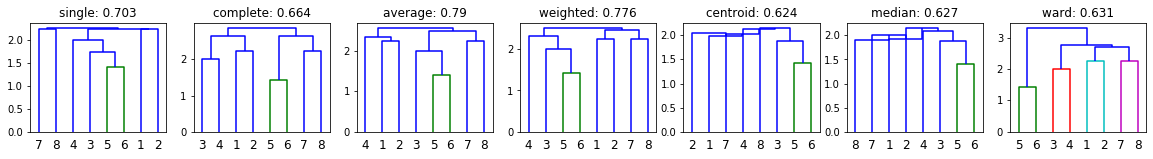

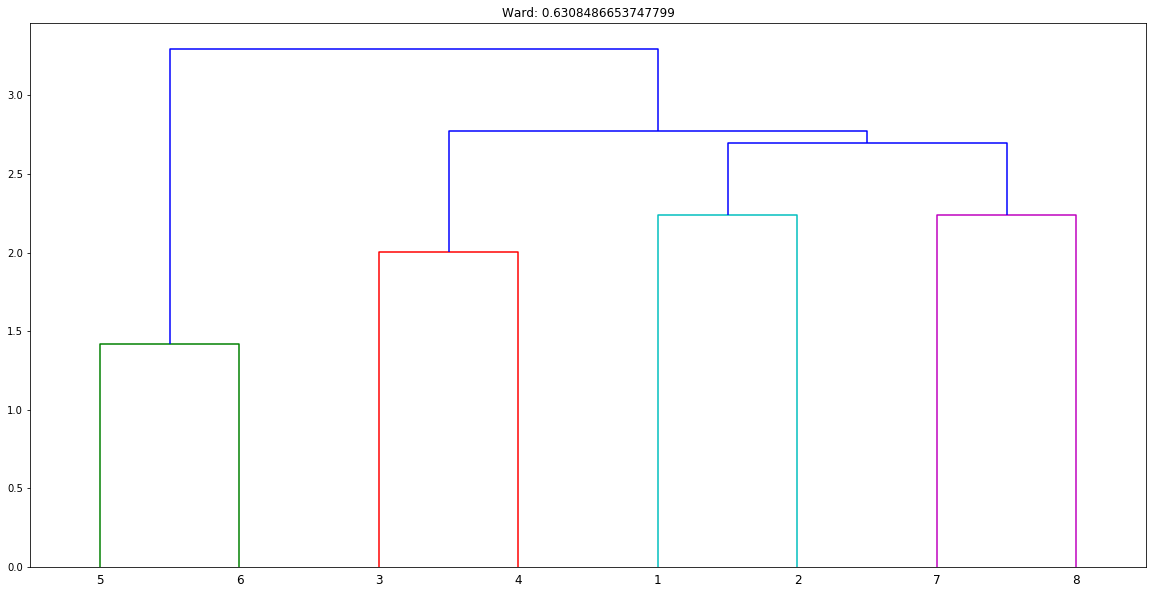

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 15       116     Значит — тмится, допойму при встрече! —  EČi     
                               117     Нет ни жизни, нет ни смерти, — третье,   ETJi    
                               118     Новое. И за него (соломой                OmaJ    
                               119     Застелив седьмой — двадцать шестому      Omu     
                               120     Отходящему — какое счастье               ASTJi   
                               121     Тобой кончиться, тобой начаться!)        Atsa    
                               122     Через стол, необозримый оком,            Okam    
                               123     Буду чокаться с тобою тихим чоком        Okam    


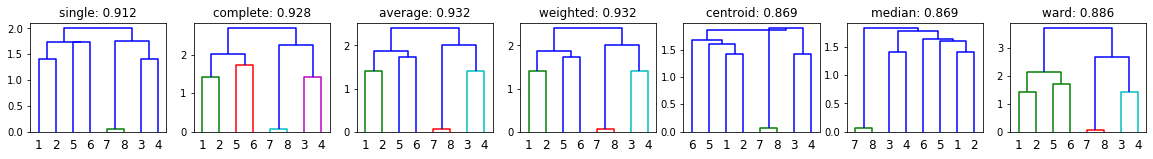

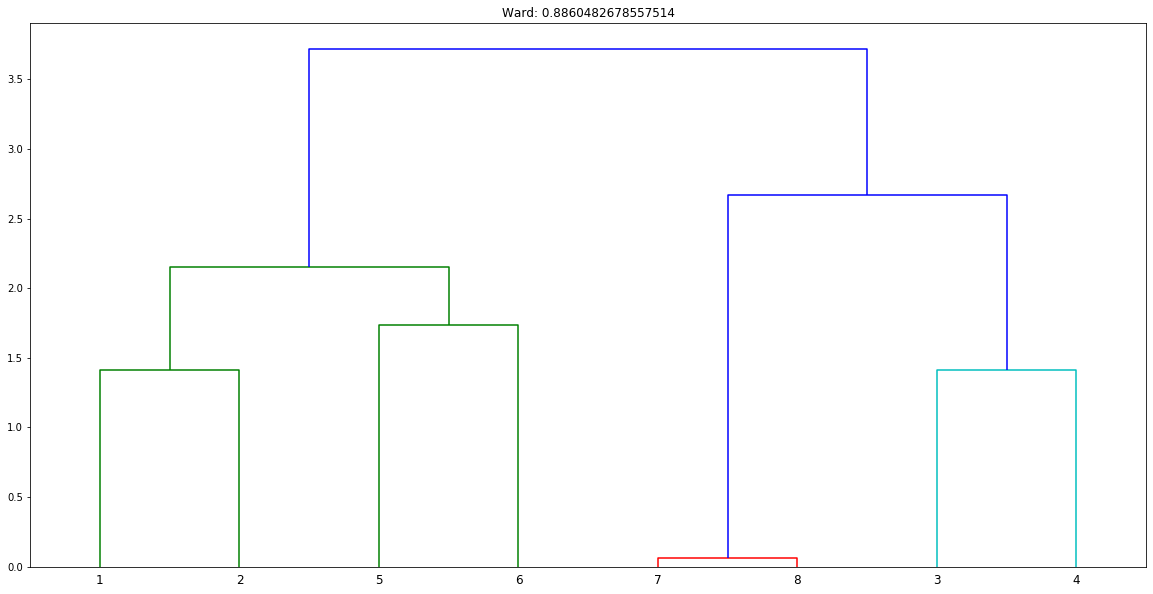

                                                                           Text RhymeZone
PoemId                StanzaNo LineNo                                                    
cvetaeva_novogodnee_y 16       124      Сткла о сткло? Нет — не кабацким ихним:  IxNim   
                               125      Я о ты, слиясь дающих рифму:             Ifmu    
                               126–127  Третье. Через стол гляжу на крест твой.  EsttvaJ 
                               128      Сколько мест — з?городных, и места       Esta    
                               129      З?городом! и кому же машет               Ašit    
                               130      Как не нам — куст? Мест — именно наших   Ašix    
                               131      И ничьих других! Весь лист! Вся хвоя!    OJi     
                               132      Мест твоих со мной (твоих с тобою).      OJu     


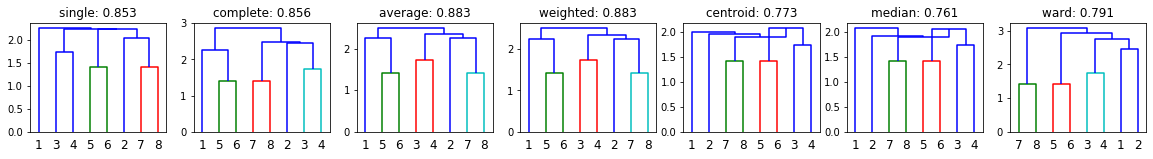

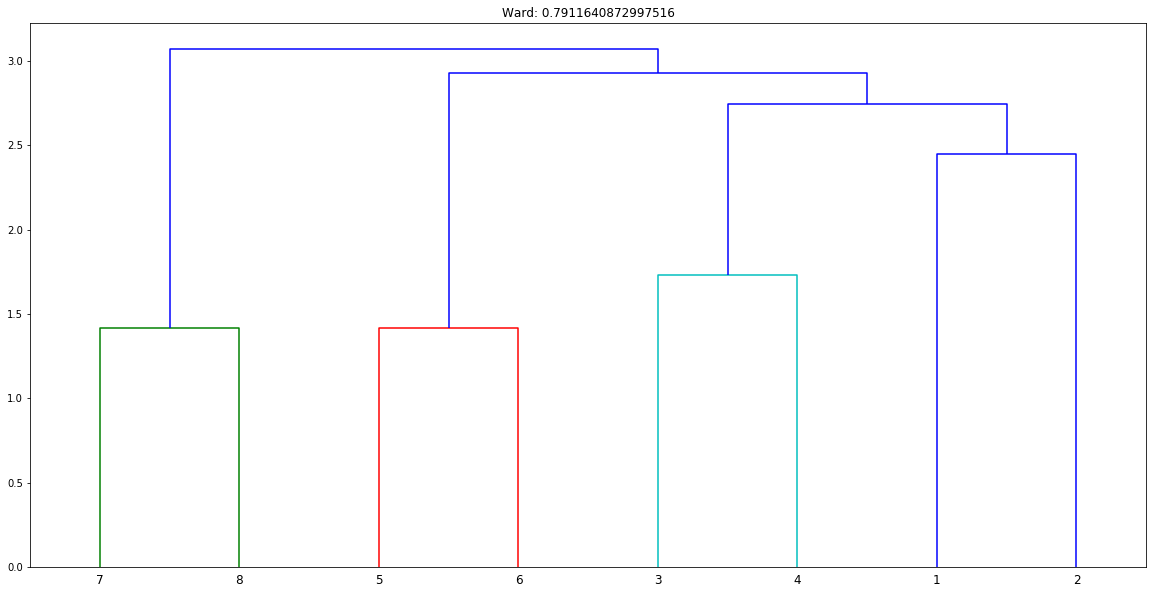

                                                                       Text RhymeZone
PoemId                StanzaNo LineNo                                                
cvetaeva_novogodnee_y 17       133     (Что с тобою бы и на массовку —       Ofku    
                               134     Говорить?) что — мест! а месяцов-то!  Of-ta   
                               135     А недель! А дождевых предместий       ESTiJ   
                               136     Без людей! А утр! А всего вместе      ESTi    
                               137     И не н?чатого соловьями!              AMi     
                               138     Верно, плохо вижу, ибо в яме,         AMi     
                               139     Верно, лучше видишь, ибо свыше:       Iši     
                               140     Ничего у нас с тобой не вышло.        Išla    


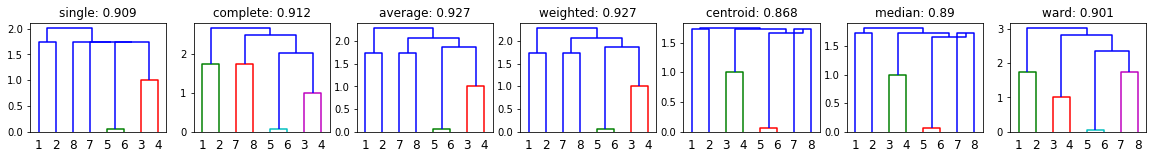

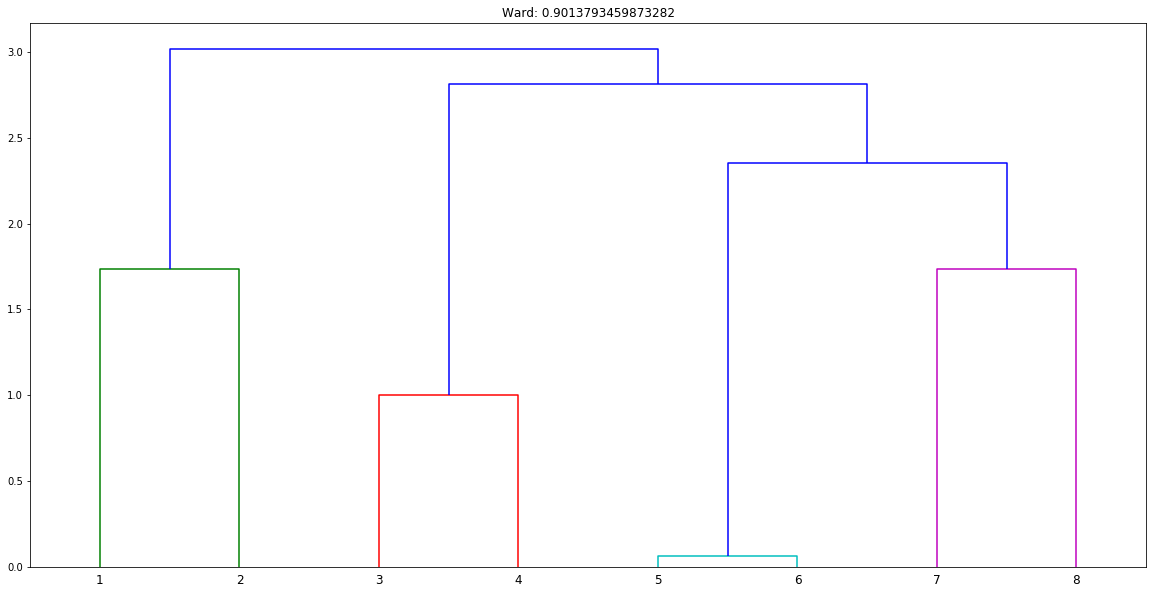

                                                                      Text RhymeZone
PoemId                StanzaNo LineNo                                               
cvetaeva_novogodnee_y 18       141      До того, так чисто и так просто     Osta    
                               142      Ничего, так по плечу и росту        Ostu    
                               143      Нам — что и перечислять не надо.    Ada     
                               144      Ничего, кроме — не жди из ряду      Adu     
                               145      Выходящего (неправ из такта         Akta    
                               146      Выходящий!) — а в какой бы, как бы  Agbi    
                               147–148  Ряд вошедшего б? Припев извечный:   EČniJ   
                               149      Ничего хоть чем-нибудь на нечто     EČta    


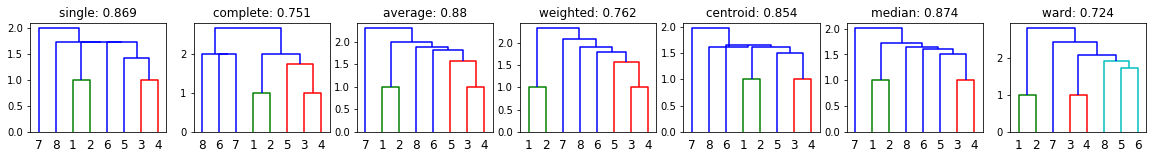

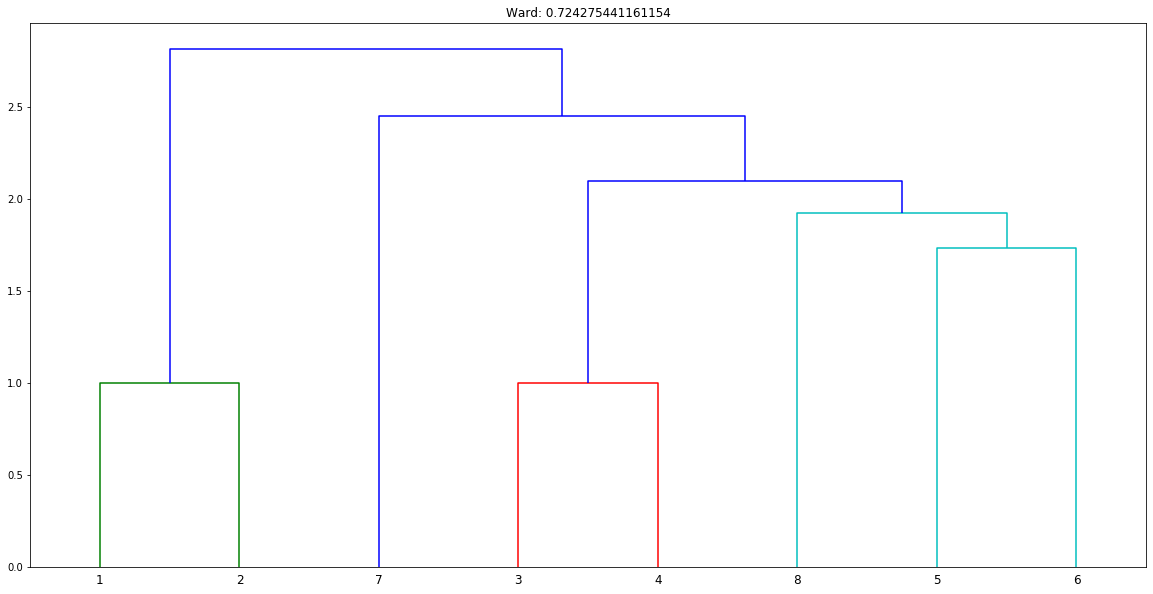

                                                                            Text RhymeZone
PoemId                StanzaNo LineNo                                                     
cvetaeva_novogodnee_y 19       150     Что-нибудь — хоть издали бы — тень хоть    ENxaT   
                               151     Тени! Ничего, что: час тот, день тот,      ENtat   
                               152     Дом тот — даже смертнику в колодках        Otkax   
                               153     Памятью дарованное: рот тот!               Ottat   
                               154     Или слишком разбирались в средствах?       Etstvax 
                               155     Из всего того один лишь свет тот           Ettat   
                               156     Наш был, как мы сами только отсвет         OtsVit  
                               157     Нас, — взамен всего сего — весь тот свет!  OtsVit  


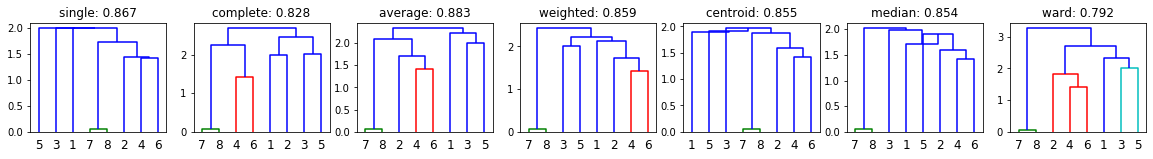

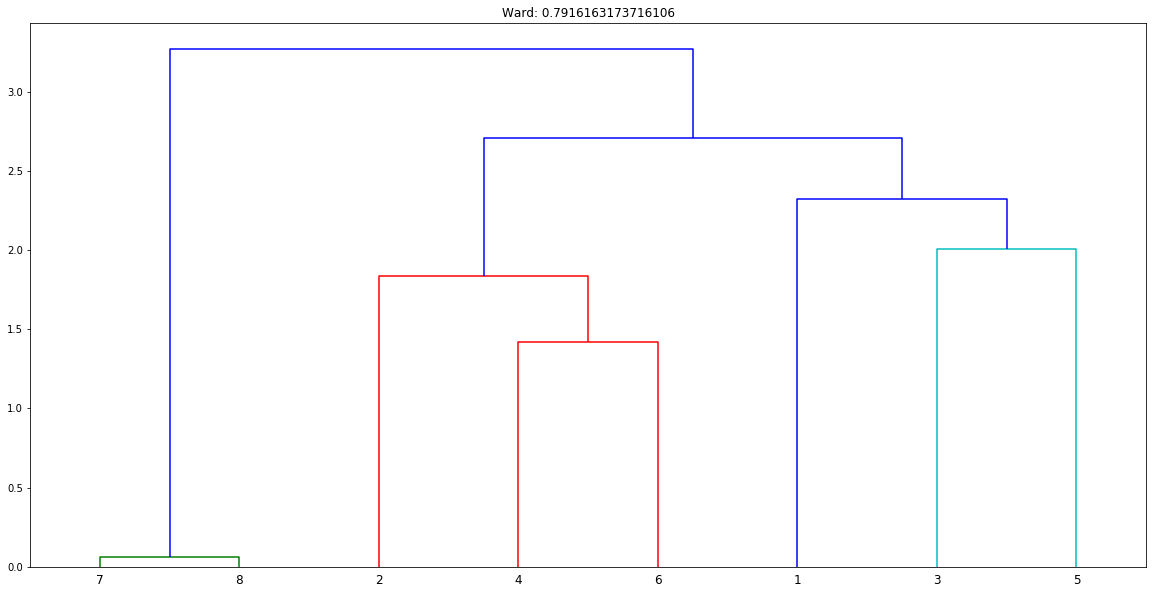

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 20       158     С незастроеннейшей из окраин —           AJin    
                               159     С новым местом, Райнер, светом, Райнер!  AJNir   
                               160     С доказуемости мысом крайним —           AJNim   
                               161     С новым оком, Райнер, слухом, Райнер!    AJNir   
                               162     Всё тебе помехой                         ExaJ    
                               163     Было: страсть и друг.                    Uk      
                               164     С новым звуком, Эхо!                     Exa     
                               165     С новым эхом, Звук!                      Uk      


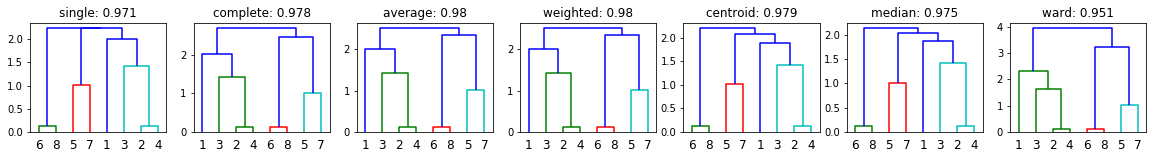

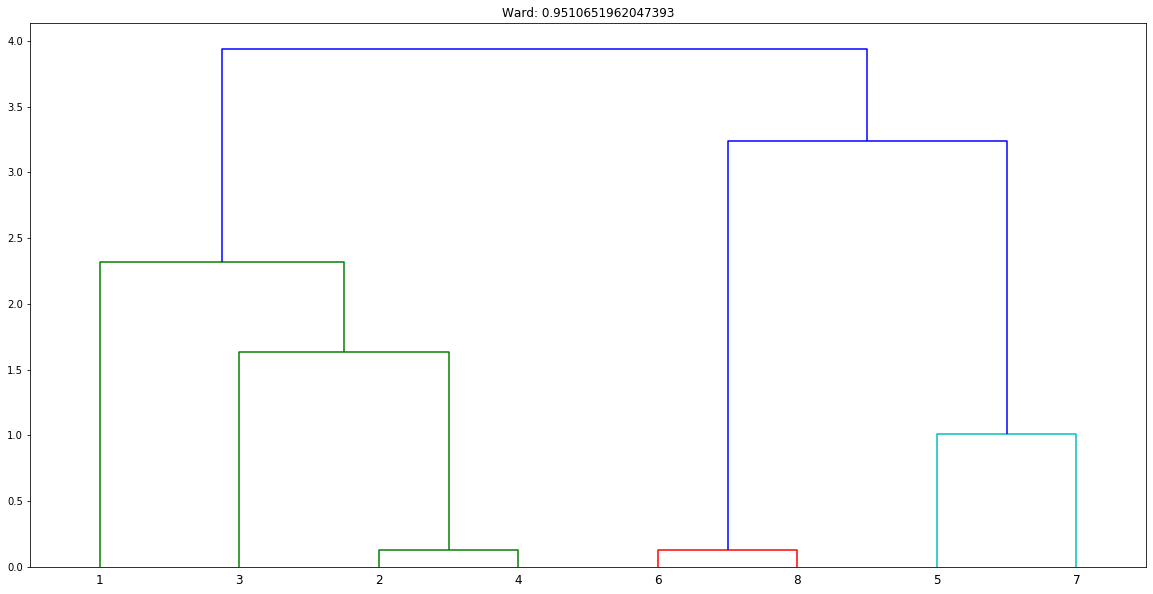

                                                                        Text RhymeZone
PoemId                StanzaNo LineNo                                                 
cvetaeva_novogodnee_y 21       166     Сколько раз на школьном табурете:      ETi     
                               167     Что за горы там? Какие реки?           EKi     
                               168     Хороши ландшафты без туристов?         Istaf   
                               169     Не ошиблась, Райнер — рай — гористый,  IstiJ   
                               170     Грозовой? Не притязаний вдовьих —      OVJix   
                               171     Не один ведь рай, над ним другой ведь  OJViT   
                               172     Рай? Террасами? Сужу по Татрам —       Atram   
                               173     Рай не может не амфитеатром            Atram   


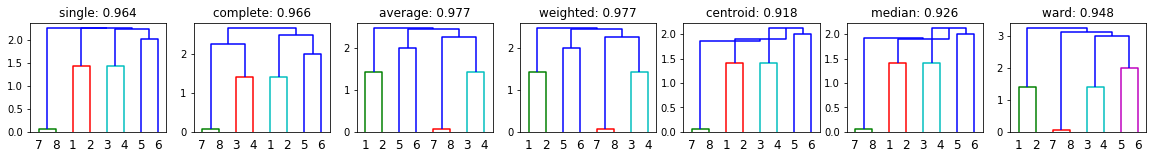

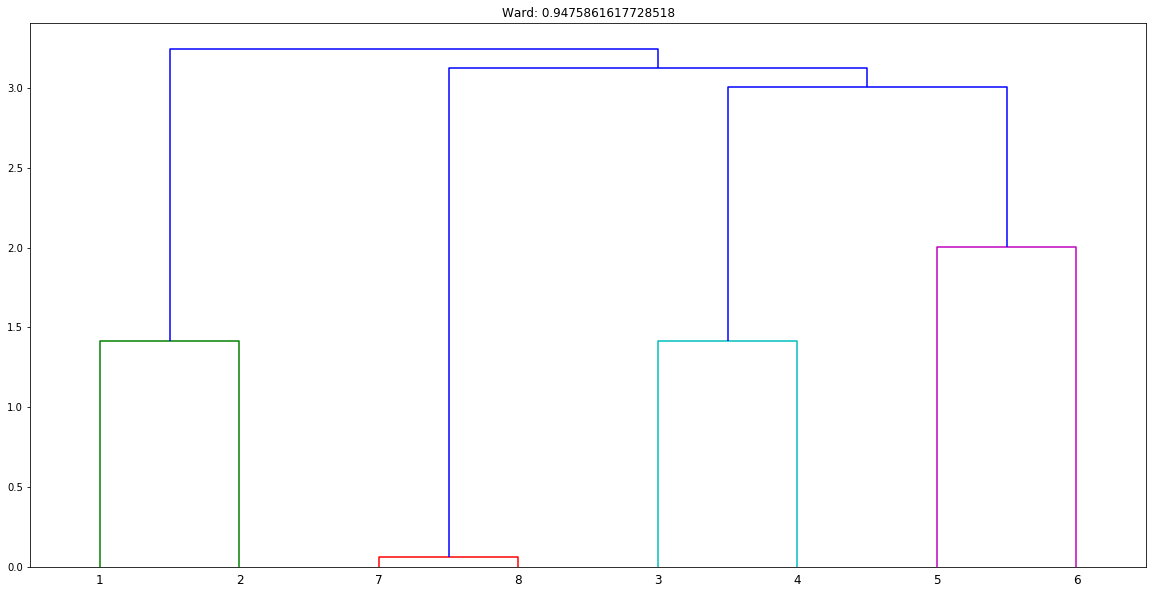

                                                                                Text RhymeZone
PoemId                StanzaNo LineNo                                                         
cvetaeva_novogodnee_y 22       174      Быть. (А занавес над кем-то спущен…)          UQin    
                               175      Не ошиблась, Райнер, Бог — растущий           UQiJ    
                               176      Баобаб? Не Золотой Людовик —                  OVik    
                               177      Не один ведь Бог? Над ним другой ведь         OJViT   
                               178–179  Бог? Как пишется на новом месте?              ESTi    
                               180      Впрочем есть ты — есть стих: сам и есть ты —  ESTti   
                               181      Стих! Как пишется в хорошей жисти             ISTi    
                               182      Без стола для локтя, лба для кисти            ISTi    


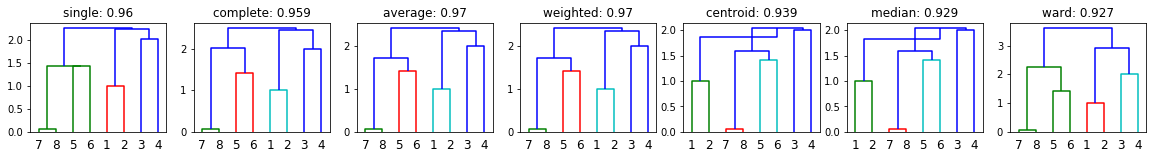

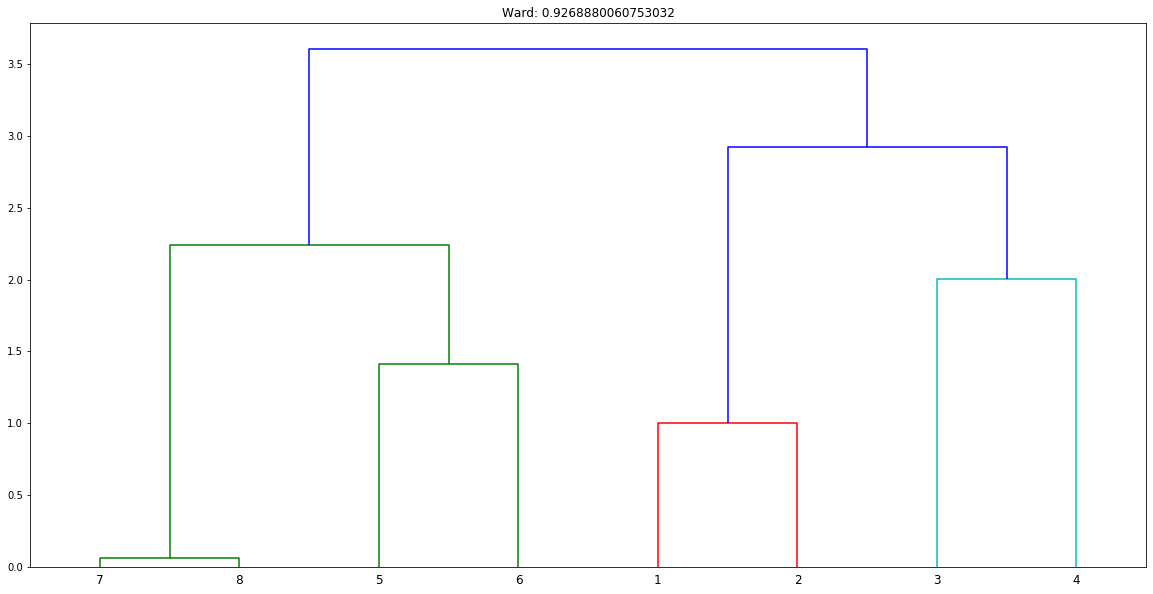

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 23       183–184  (Горсти) — Весточку, привычным шифром!  Ifram   
                               185      Райнер, радуешься новым рифмам?         Ifmam   
                               186      Ибо правильно толкуя слово              Ova     
                               187      Рифма — что — как не — целый ряд новых  Ovix    
                               188–189  Рифм — Смерть? Некуда: язык изучен.     UČin    
                               190      Целый ряд значений и созвучий           UČiJ    
                               191–192  Новых. — До свиданья! До знакомства!    Omstva  
                               193      Свидимся — не знаю, но — споёмся.       OmSi    


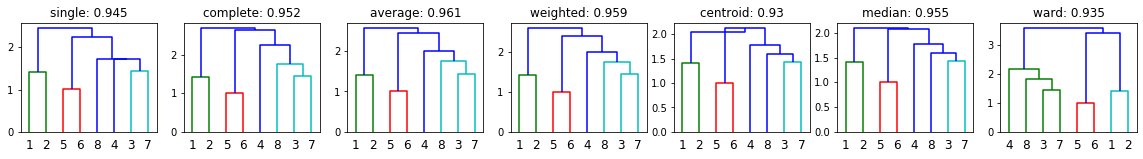

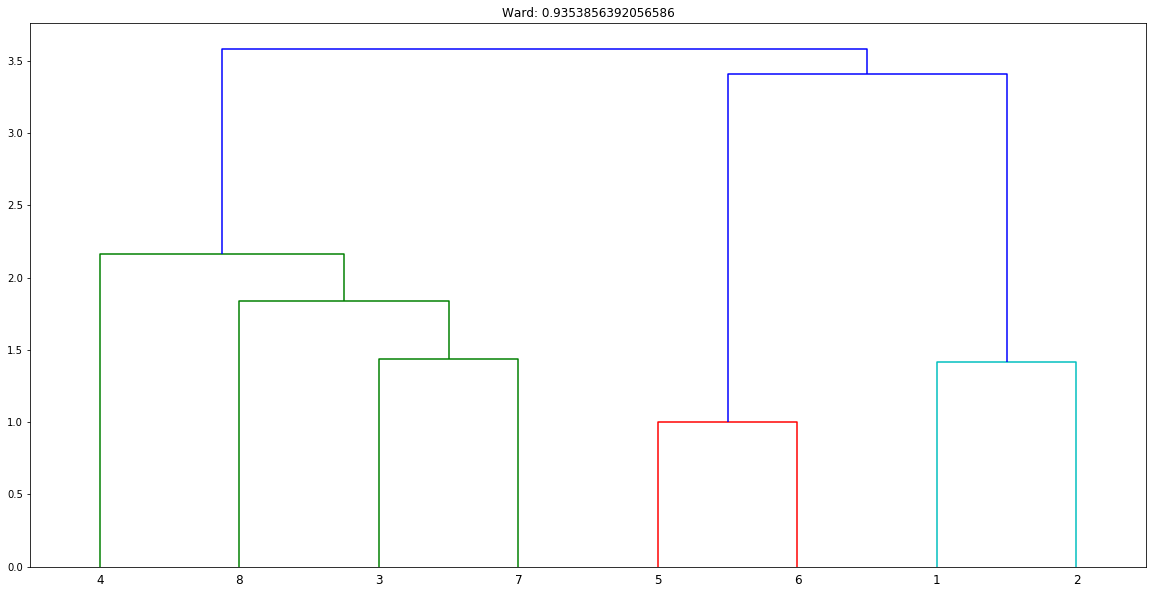

                                                                       Text RhymeZone
PoemId                StanzaNo LineNo                                                
cvetaeva_novogodnee_y 24       194     С мне-самой неведомой землёю —        OJu     
                               195     С целым морем, Райнер, с целой мною!  OJu     
                               196     Не разъехаться — черкни заране.       ANi     
                               197     С новым звуконачертаньем, Райнер!     AJNir   
                               198     В небе лестница, по ней с Дарами…     AMi     
                               199     С новым рукоположеньем, Райнер!       AJNir   
                               200     — Чтоб не залили, держу ладонью. —    ONJu    
                               201     Поверх Роны и поверх Rarogn’a         Ogna    


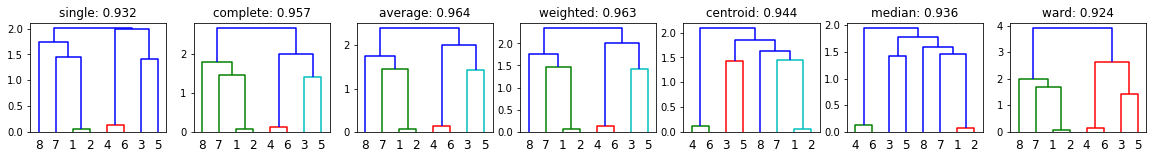

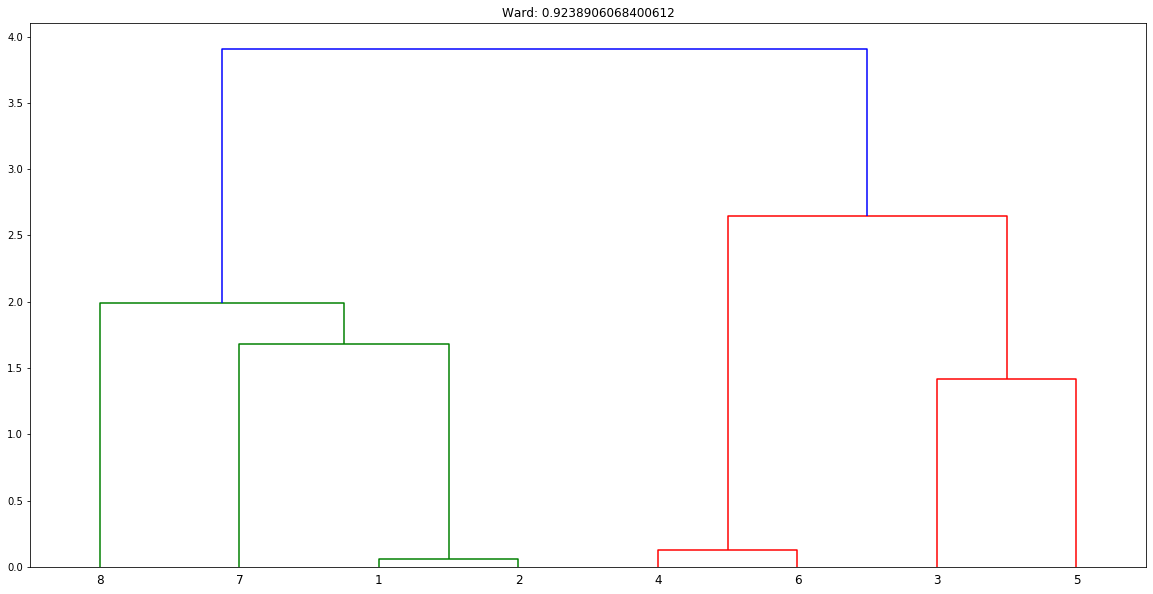

                                                                     Text RhymeZone
PoemId                StanzaNo LineNo                                              
cvetaeva_novogodnee_y 25       202     Поверх явной и сплошной разлуки     UKi     
                               203     Райнеру — Мария — Рильке — в руки.  UKi     


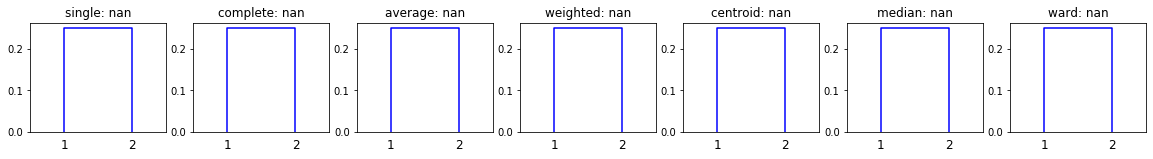

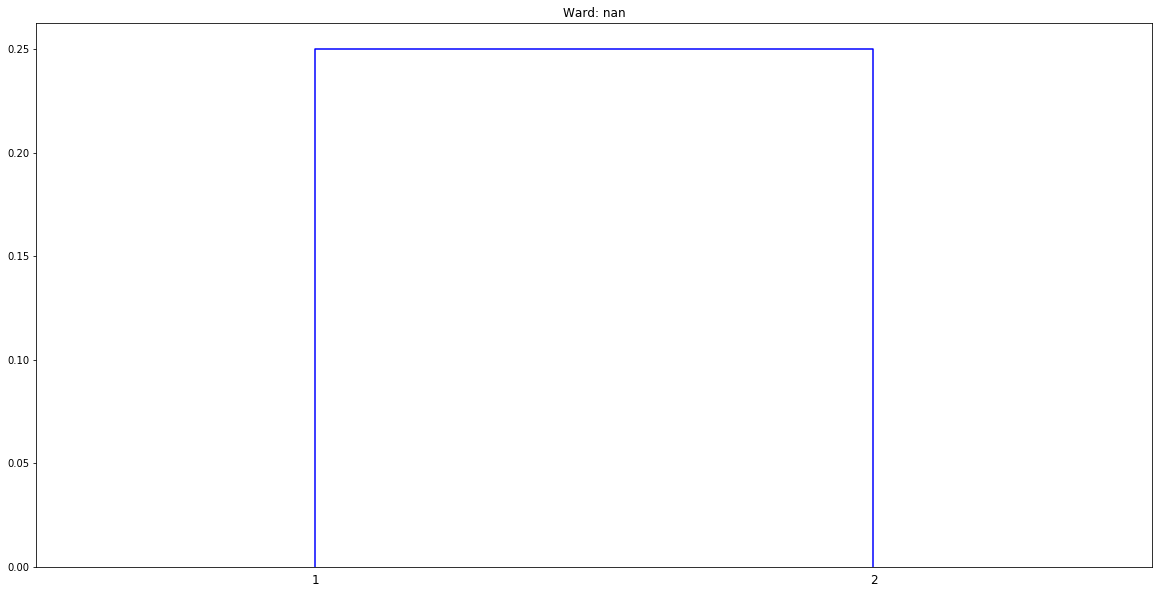

Text  \
PoemId                StanzaNo LineNo                                                                                                            
cvetaeva_novogodnee_y 1        001      <line lineNo="001">С Новым годом — светом — краем — кр<stress>о</stress>вом!</line>                      
                               002      <line lineNo="002">Первое письмо тебе на н<stress>о</stress>вом</line>                                   
                               003      <line lineNo="003">— Недоразумение, что зл<stress>а</stress>чном —</line>                                
                               004      <line lineNo="004">(Злачном — жвачном) месте зычном, месте зв<stress>у</stress>чном</line>               
                               005      <line lineNo="005">Как Эолова пустая б<stress>а</stress>шня.</line>                                      
                               006      <line lineNo="006">Первое письмо тебе с вчер<stress>а</stress>шней,</line>                               
                               007      <line lineNo="007">На которой без тебя изн<stress>о</stress>юсь,</line>                                  
                               008      <line lineNo="008">Родины, теперь уже с одн<stress>о</stress>й из</line>                                 
                      2        009      <line lineNo="009">Звезд… Закон отхода и отб<stress>о</stress>я,</line>                                  
                               010      <line lineNo="010">По которому любимая люб<stress>о</stress>ю</line>                                     
                               011      <line lineNo="011">И небывшею из небыв<stress>а</stress>лой.</line>                                      
                               012      <line lineNo="012">Рассказать, как про твою узн<stress>а</stress>ла?</line>                              
                               013      <line lineNo="013">Не землетрясенье, не лав<stress>и</stress>на.</line>                                  
                               014      <line lineNo="014">Человек вошел — любой — (люб<stress>и</stress>мый —</line>                            
                               015      <line lineNo="015">Ты). — Прискорбнейшее из соб<stress>ы</stress>тий.</line>                             
                               016      <line lineNo="016">— В Новостях и в Днях. — Статью дад<stress>и</stress>те?</line>                       
                      3        017      <line lineNo="017">— Где? — В горах. (Окно в еловых в<stress>е</stress>тках.</line>                      
                               018      <line lineNo="018">Простыня.) — Не видите газ<stress>е</stress>т ведь?</line>                            
                               019      <line lineNo="019">Так статью? — Нет. — Но… — Прошу изб<stress>а</stress>вить.</line>                    
                               020      <line lineNo="020">Вслух: трудна. Внутрь: не христопрод<stress>а</stress>вец.</line>                     
                               021      <line lineNo="021">— В санатории. (В раю на<stress>ё</stress>мном.)</line>                               
                               022      <line lineNo="022">— День? — Вчера, позавчера, не п<stress>о</stress>мню.</line>                         
                               023      <line lineNo="023">В Альказаре будете? — Не б<stress>у</stress>ду.</line>                                
                               024      <line lineNo="024">Вслух: семья. Внутрь: всё, но не И<stress>у</stress>да.</line>                        
                      4        025      <line lineNo="025">С наступающим! (Рождался з<stress>а</stress>втра!) —</line>                           
                               026      <line lineNo="026">Рассказать, что сделала, узн<stress>а</stress>в про..?</line>                         
                               027      <line line

In [20]:
explore("data_samples/cvetaeva_novogodnee_y.xml",100,True)